# Huấn luyện và Đánh giá Mô hình (Modeling & Evaluation)
Trong notebook này, chúng ta sẽ xây dựng các mô hình học máy để giải quyết hai bài toán chính dựa trên dữ liệu đã làm sạch:
- **Task A (Hồi quy):** Dự đoán số lượng `Retweets` (mức độ lan truyền) dựa trên các đặc trưng của người dùng.
- **Task B (Phân loại):** Dự đoán tài khoản có phải là `Verified` (đã xác minh) hay không.

**Các mô hình sử dụng:**
- **K-Nearest Neighbors (KNN):** Dùng cho bài toán hồi quy.
- **Logistic Regression:** Dùng cho bài toán phân loại.

## 0. Import thư viện và các module đã chuẩn bị

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Thêm đường dẫn để import module nếu cần
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

import src.models as md

## 1. Chuẩn bị dữ liệu
Load dữ liệu đã qua xử lý từ file CSV.
* **Input (X):** Các đặc trưng như `Followers (Log)`, `Friends (Std)`, `Account Age`.
* **Target (y):**
    * `y_reg`: Số lượng Retweets (đã xử lý missing value).
    * `y_cls`: Nhãn Verified (0 hoặc 1).

In [2]:
data_path = '../data/processed/processed_dataset.csv'

raw_data = np.loadtxt(data_path, delimiter=",")
print(f"Data Loaded Shape: {raw_data.shape}")

X = raw_data[:, :3] # Features
y_reg = raw_data[:, 3] # Target Regression
y_cls = raw_data[:, 4] # Target Classification

Data Loaded Shape: (5917, 5)


## 2. Task A: Dự đoán số lượng Retweets (Regression)

Chúng ta chia dữ liệu thành tập **Train (80%)** để huấn luyện và **Test (20%)** để kiểm thử.

**Giải thích mô hình: K-Nearest Neighbors (KNN) Regressor**
KNN là một thuật toán "học lười" (lazy learning), không cần quá trình huấn luyện phức tạp mà ghi nhớ toàn bộ dữ liệu.

**Cơ chế hoạt động:**
- **Tính khoảng cách:** Khi cần dự đoán cho một điểm dữ liệu mới, thuật toán tính khoảng cách (thường là Euclidean) từ điểm đó đến tất cả các điểm trong tập Train.
- **Tìm láng giềng:** Chọn ra **$k$** điểm gần nhất (Neighbors).
- **Dự đoán:**
    - Với bài toán Hồi quy (Regression): Kết quả là **trung bình cộng** giá trị target của $k$ láng giềng đó.
    - Công thức: $\hat{y} = \frac{1}{k} \sum_{i=1}^{k} y_i$

**Tại sao chọn KNN?**
Mô hình này đơn giản, dễ hiểu và hoạt động tốt khi dữ liệu có cấu trúc cục bộ rõ ràng (những người dùng có đặc điểm giống nhau thường có mức tương tác giống nhau).

### a. Huấn luyện mô hình Linear Regression

--- TASK A: PREDICT RETWEETS (Regression) ---
Linear Regression GD -> MSE: 15.9308, R2: 0.0187


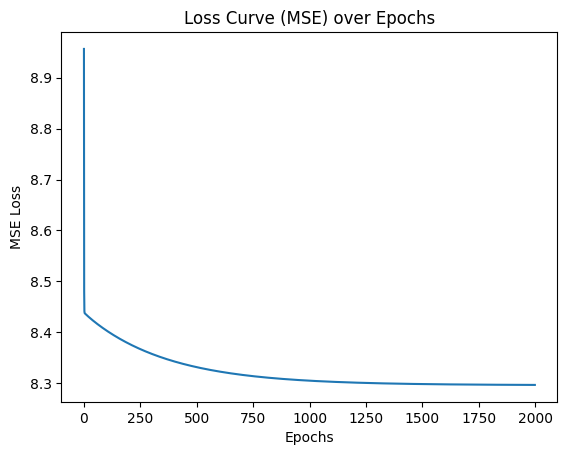

In [3]:
print("--- TASK A: PREDICT RETWEETS (Regression) ---")

# 1. Chia train/test (80/20) thủ công
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)
split = int(0.8 * len(X))

train_idx, test_idx = indices[:split], indices[split:]
X_train, y_train = X[train_idx], y_reg[train_idx]
X_test, y_test = X[test_idx], y_reg[test_idx]

# 2. Huấn luyện Linear Regression (Gradient Descent)
lr_model = md.LinearRegressionGD(learning_rate=0.01, epochs=2000)
lr_model.fit(X_train, y_train)

# 3. Dự đoán và Đánh giá
y_pred_lr = lr_model.predict(X_test)
mse_lr = md.mean_squared_error(y_test, y_pred_lr)
r2_lr = md.r2_score(y_test, y_pred_lr)

print(f"Linear Regression GD -> MSE: {mse_lr:.4f}, R2: {r2_lr:.4f}")

# 4. Vẽ biểu đồ Loss
plt.plot(lr_model.history)
plt.title("Loss Curve (MSE) over Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.show()

### b. Huấn luyện mô hình KNN

In [4]:
# 1. Huấn luyện KNN Regressor
knn_reg = md.KNN(k=5, mode='regression')
knn_reg.fit(X_train, y_train)

# 2. Dự đoán
y_pred_knn = knn_reg.predict(X_test)

# 3. Đánh giá
mse_knn = md.mean_squared_error(y_test, y_pred_knn)
r2_knn = md.r2_score(y_test, y_pred_knn)

print(f"KNN Regression (k=5) -> MSE: {mse_knn:.4f}, R2: {r2_knn:.4f}")

# So sánh
print("\n>>> KẾT LUẬN TASK A:")
if mse_knn < mse_lr:
    print("KNN hoạt động tốt hơn Linear Regression trên tập dữ liệu này.")
else:
    print("Linear Regression hoạt động tốt hơn KNN.")

KNN Regression (k=5) -> MSE: 17.6912, R2: -0.0897

>>> KẾT LUẬN TASK A:
Linear Regression hoạt động tốt hơn KNN.


## 3. Task B: Dự đoán tài khoản Verified (Classification)

Đây là bài toán phân loại nhị phân (Binary Classification): Tài khoản là Verified (1) hay Unverified (0).

### Mô hình: Logistic Regression
Dù tên gọi là "Hồi quy", Logistic Regression thực chất là thuật toán nền tảng cho **Phân loại**.

**Cơ chế hoạt động:**
- **Tổ hợp tuyến tính:** Mô hình tính tổng có trọng số các đặc trưng đầu vào (tương tự Linear Regression).
    $$z = w_1x_1 + w_2x_2 + ... + b$$
- **Hàm kích hoạt (Activation):** Sử dụng hàm **Sigmoid** để nén giá trị $z$ vào khoảng $(0, 1)$, đại diện cho xác suất.
    $$\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}$$
- **Ra quyết định:** Nếu xác suất $\hat{y} \geq 0.5 \rightarrow$ Dự đoán là 1 (Verified), ngược lại là 0.

**Quá trình huấn luyện (Training):**
Mô hình tìm bộ trọng số $w$ tối ưu bằng cách giảm thiểu Hàm mất mát (Log-Loss) thông qua thuật toán Gradient Descent (Xuống đồi).

In [5]:
print("\n--- TASK B: PREDICT VERIFIED STATUS (Classification) ---")

# Sử dụng y_cls
y_train_cls = y_cls[train_idx]
y_test_cls = y_cls[test_idx]

# 1. Logistic Regression (từ file models.py)
log_reg = md.LogisticRegressionNP(lr=0.1, epochs=3000)
losses = log_reg.fit(X_train, y_train_cls)
y_pred_log = log_reg.predict(X_test)

# 2. Đánh giá
acc = md.accuracy(y_test_cls, y_pred_log)
pre = md.precision(y_test_cls, y_pred_log)
rec = md.recall(y_test_cls, y_pred_log)
f1 = md.f1_score(y_test_cls, y_pred_log)

print(f"Logistic Regression Results:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {pre:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-Score : {f1:.4f}")


--- TASK B: PREDICT VERIFIED STATUS (Classification) ---
Logistic Regression Results:
  Accuracy : 0.9814
  Precision: 0.0000
  Recall   : 0.0000
  F1-Score : 0.0000


Để đánh giá hiệu quả mô hình phân loại, chúng ta không chỉ nhìn vào độ chính xác (Accuracy) mà cần quan tâm đến các chỉ số chi tiết hơn, đặc biệt khi dữ liệu bị mất cân bằng (số lượng Verified rất ít so với Unverified):

* **Precision (Độ chính xác của dự báo đúng):** Trong số các tài khoản mô hình *dự đoán* là Verified, bao nhiêu % thực sự là Verified?
* **Recall (Độ phủ):** Trong số các tài khoản *thực tế* là Verified, mô hình tìm ra được bao nhiêu %?
* **F1-Score:** Trung bình điều hòa giữa Precision và Recall. Đây là chỉ số quan trọng nhất khi dữ liệu mất cân bằng.